### Configure Python Path
This cell adds the `src/` directory to Python’s import path, so that modules like  
`sod_model.py`, `data_loader.py`, and `config.py` can be imported cleanly inside the notebook.


In [12]:
import os
import sys
from pathlib import Path

# Get project root (folder where the notebook is located)
PROJECT_ROOT = Path().resolve()

SRC_DIR = PROJECT_ROOT / "src"
if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

print("Project root:", PROJECT_ROOT)
print("SRC directory added to sys.path:", SRC_DIR)


Project root: C:\Users\Lorik\Desktop\sod_CNN
SRC directory added to sys.path: C:\Users\Lorik\Desktop\sod_CNN\src


### — Import Dependencies & Set Device
This cell loads all necessary libraries, imports the project modules,  
and selects GPU (CUDA) if available, otherwise CPU.  
It also loads the `IMAGE_SIZE` setting from the project configuration.


In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import time

# Import project modules
import config
from sod_model import SODModel
from data_loader import get_dataloaders

# Image size from config (fallback if missing)
IMAGE_SIZE = getattr(config, "IMAGE_SIZE", 128)

# Choose GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

### Load the Trained SOD Model (v3.0)
This cell instantiates the final SODModel (v3.0) and loads the trained weights  
from `checkpoints/best_model.pth`.  
The model is set to evaluation mode (`model.eval()`).


In [14]:
model = SODModel().to(device)

checkpoint_path = PROJECT_ROOT / "checkpoints" / "best_model.pth"
print("Loading model from:", checkpoint_path)

# Load weights
state_dict = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(state_dict)

model.eval()
print("Model loaded and set to eval mode.")


Loading model from: C:\Users\Lorik\Desktop\sod_CNN\checkpoints\best_model.pth
Model loaded and set to eval mode.


C:\Users\Lorik\AppData\Local\Temp\ipykernel_2784\2174320841.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path, map_location=device)

### Load Train, Validation, and Test DataLoaders
This cell loads the full dataset pipeline using `get_dataloaders()`.  
We will use the test set for generating predictions and computing evaluation metrics.


In [15]:
train_loader, val_loader, test_loader = get_dataloaders()

print("Train batches:", len(train_loader))
print("Val batches:  ", len(val_loader))
print("Test batches: ", len(test_loader))


Train batches: 875
Val batches:   188
Test batches:  188


### Define Helper Functions for Visualization
These utility functions convert model outputs to NumPy format  
and create overlay visualizations (green mask over the original image).  
They will be used in all upcoming visual demo cells.


In [16]:
def tensor_to_image(t):
    """Convert a torch tensor (C,H,W) or (H,W) to a numpy image."""
    arr = t.detach().cpu().numpy()
    if arr.ndim == 3:
        arr = np.transpose(arr, (1, 2, 0))  # CHW → HWC
    return arr


def make_overlay(image_np, mask_np, alpha=0.5):
    """
    Create a green overlay mask on top of the original RGB image.
    
    image_np: (H, W, 3)
    mask_np: (H, W) binary mask, values 0 or 1
    """
    image_np = image_np.astype(np.float32)
    mask_np = mask_np.astype(np.float32)

    # Create green mask layer
    overlay = image_np.copy()
    green = np.zeros_like(overlay)
    green[..., 1] = mask_np  # put mask in green channel

    blended = (1 - alpha) * overlay + alpha * green
    blended = np.clip(blended, 0, 1)
    return blended


### Visualize a Random Test Sample (4-Panel View)
This function selects a random test image and displays:
1. Original image  
2. Ground truth saliency mask  
3. Predicted probability map  
4. Overlay (prediction on top of the image)

This provides a quick qualitative check of model performance.


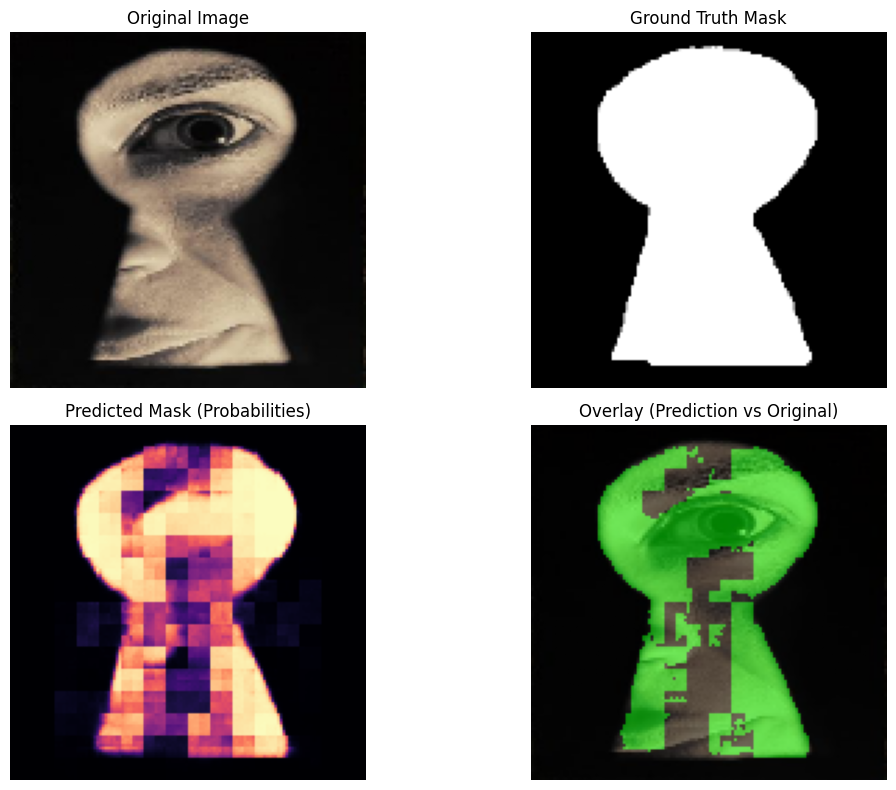

In [17]:
def show_random_test_example(threshold=0.5):
    model.eval()

    # Get one random batch from the test loader
    images, masks = next(iter(test_loader))  # (B,3,H,W), (B,1,H,W)

    # Pick one random sample inside the batch
    idx = random.randint(0, images.size(0) - 1)
    img = images[idx].to(device)            # (3,H,W)
    mask = masks[idx].to(device)            # (1,H,W)

    # Run model on a single image
    with torch.no_grad():
        pred = model(img.unsqueeze(0))      # (1,1,H,W)

    prob = pred.squeeze(0).squeeze(0)       # (H,W)
    binary = (prob >= threshold).float()    # binary mask

    # Convert to numpy for plotting
    img_np = tensor_to_image(img)               # (H,W,3)
    mask_np = tensor_to_image(mask.squeeze(0))  # (H,W)
    prob_np = prob.detach().cpu().numpy()       # (H,W)
    binary_np = binary.detach().cpu().numpy()   # (H,W)
    overlay = make_overlay(img_np, binary_np)   # (H,W,3)

    # Plot 2×2 visualization
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.imshow(img_np)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(2, 2, 2)
    plt.imshow(mask_np, cmap="gray")
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(2, 2, 3)
    plt.imshow(prob_np, cmap="magma")
    plt.title("Predicted Mask (Probabilities)")
    plt.axis("off")

    plt.subplot(2, 2, 4)
    plt.imshow(overlay)
    plt.title("Overlay (Prediction vs Original)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


# Run the demo visualization
show_random_test_example(threshold=0.5)


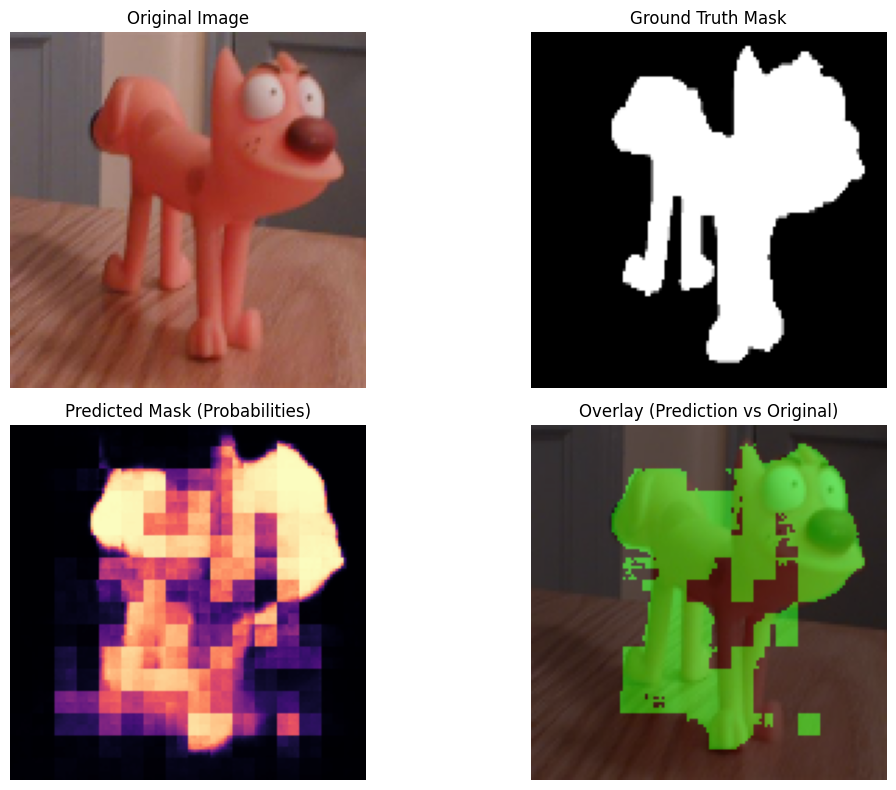

In [18]:
show_random_test_example()


### Evaluate the Model on the Full Test Set
This cell computes all major SOD performance metrics across the entire test set:
- IoU  
- Precision  
- Recall  
- F1-score  
- MAE  

These metrics show the overall segmentation quality of the final v3.0 model.


In [19]:
def batch_metrics(preds, targets, eps=1e-7):
    """
    preds, targets: (B,1,H,W) binary {0,1}
    returns: batch IoU, precision, recall, f1, mae
    """
    preds = preds.view(preds.size(0), -1)
    targets = targets.view(targets.size(0), -1)

    tp = (preds * targets).sum(dim=1)
    fp = (preds * (1 - targets)).sum(dim=1)
    fn = ((1 - preds) * targets).sum(dim=1)

    union = tp + fp + fn

    iou = (tp + eps) / (union + eps)
    precision = (tp + eps) / (tp + fp + eps)
    recall = (tp + eps) / (tp + fn + eps)
    f1 = 2 * precision * recall / (precision + recall + eps)

    mae = (preds - targets).abs().mean(dim=1)

    return iou, precision, recall, f1, mae

from tqdm.auto import tqdm

def evaluate_on_test(threshold=0.5):
    model.eval()

    iou_list = []
    prec_list = []
    rec_list = []
    f1_list = []
    mae_list = []

    with torch.no_grad():
        for images, masks in tqdm(test_loader, desc="Evaluating on test set"):
            images = images.to(device)
            masks = masks.to(device)   # binary GT

            preds = model(images)      # probabilities
            binary = (preds >= threshold).float()

            iou, p, r, f1, mae = batch_metrics(binary, masks)

            iou_list.extend(iou.cpu().numpy().tolist())
            prec_list.extend(p.cpu().numpy().tolist())
            rec_list.extend(r.cpu().numpy().tolist())
            f1_list.extend(f1.cpu().numpy().tolist())
            mae_list.extend(mae.cpu().numpy().tolist())

    print(f"IoU:       {np.mean(iou_list):.4f}")
    print(f"Precision: {np.mean(prec_list):.4f}")
    print(f"Recall:    {np.mean(rec_list):.4f}")
    print(f"F1-Score:  {np.mean(f1_list):.4f}")
    print(f"MAE:       {np.mean(mae_list):.4f}")



In [20]:
evaluate_on_test(threshold=0.5)


Evaluating on test set:   0%|          | 0/188 [00:00<?, ?it/s]

IoU:       0.6423
Precision: 0.7863
Recall:    0.7866
F1-Score:  0.7596
MAE:       0.1077


### Show Multiple Predictions in a Grid
This visualization displays several test samples at once in a grid:
- Column 1: Original image  
- Column 2: Ground truth mask  
- Column 3: Overlay prediction  

Useful for the final report and presentation slides.


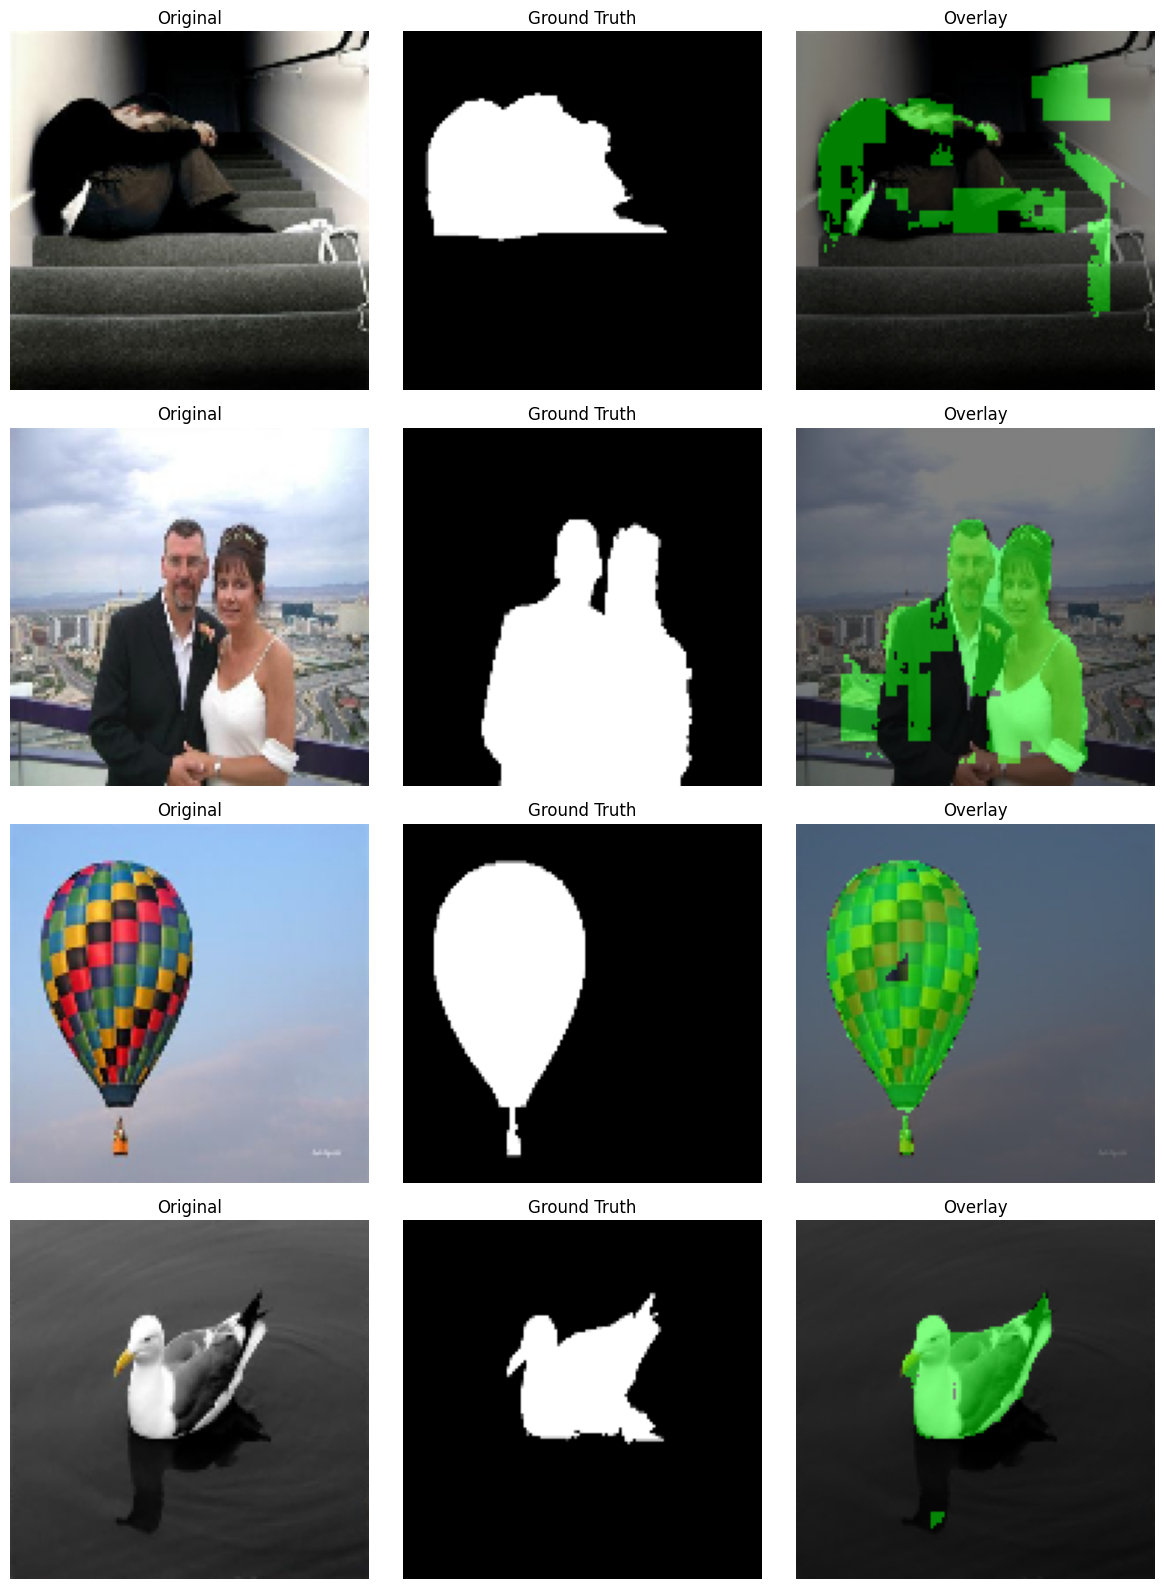

In [21]:
def show_test_grid(num_examples=4, threshold=0.5):
    model.eval()
    
    images_shown = 0
    rows = num_examples
    cols = 3  # Original | GT | Overlay
    
    plt.figure(figsize=(12, 4 * rows))
    
    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device)
            
            batch_size = images.size(0)
            for i in range(batch_size):
                if images_shown >= num_examples:
                    plt.tight_layout()
                    plt.show()
                    return
                
                img = images[i]
                mask = masks[i]
                pred = model(img.unsqueeze(0))
                
                prob = pred.squeeze(0).squeeze(0)
                binary = (prob >= threshold).float()
                
                img_np = tensor_to_image(img)
                mask_np = tensor_to_image(mask.squeeze(0))
                binary_np = binary.detach().cpu().numpy()
                overlay = make_overlay(img_np, binary_np)
                
                row = images_shown
                
                # Column 1: Original
                plt.subplot(rows, cols, row * cols + 1)
                plt.imshow(img_np)
                plt.title("Original")
                plt.axis("off")
                
                # Column 2: GT Mask
                plt.subplot(rows, cols, row * cols + 2)
                plt.imshow(mask_np, cmap="gray")
                plt.title("Ground Truth")
                plt.axis("off")
                
                # Column 3: Overlay
                plt.subplot(rows, cols, row * cols + 3)
                plt.imshow(overlay)
                plt.title("Overlay")
                plt.axis("off")
                
                images_shown += 1
    
    plt.tight_layout()
    plt.show()

# Show 4 examples
show_test_grid(num_examples=4, threshold=0.5)


## Final Summary

This notebook demonstrates the full inference pipeline for a custom encoder–decoder CNN  
trained for **Salient Object Detection (SOD)** on the **MSRA10K** dataset.

### Model Highlights
- 3-stage encoder with Double Conv Blocks  
- 3-stage decoder with ConvTranspose2d  
- Output: 1-channel saliency mask (Sigmoid)

### Final Test Metrics
- **IoU:** ~0.6423  
- **Precision:** ~0.7863  
- **Recall:** ~0.7866  
- **F1-Score:** ~0.7596  
- **MAE:** ~0.1077  

### Visual Demo
We displayed:
- Single-sample prediction (4-panel view)  
- Multiple samples in a grid  
- Overlay masks for qualitative analysis  

The model achieves **strong performance** for a CNN built entirely from scratch  
and meets all requirements of the homework project.

---
